# İş Akışı ve Hiperparametre Optimizasyonu

In [66]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt


🏠 Ev fiyatları veri setini içe aktarın. Basitlik adına sadece sayısal özellikleri tutacağız

🎯 Hedefiniz en iyi KNN Regressor'ı yerleştirmek olacak. Özellikle, ev fiyatlarınız için en iyi tahminleri elde etmek üzere kaç tane "komşu" (<font color=blue>K</font>NN'deki <font color=blue>K</font>) göz önünde bulundurmalısınız?

In [67]:
# Load raw data
data = pd.read_csv('https://d32aokrjazspmn.cloudfront.net/materials/houses_train_raw.csv', index_col="Id")

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500


In [68]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Eğitim/Test Ayrımı

❓ **Soru (Holdout)**❓

👇 `X_train`, `X_test`, `y_train` ve `y_test` oluşturmak için veri setini böl. Şunları kullan:
- `test_size=0.3`
- Sonuçlarınızı arkadaşınızla karşılaştırmak için `random_state=0`

In [69]:
X_train,X_test,y_train,y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)


## 2. Ölçeklendirme

⚖️ Ölçeklendirme KNN algoritması için her zaman kritik derecede önemlidir..

❓ **Soru (Ölçeklendirme)** ❓ 

* Eğitim setinizi ve test setinizi ölçeklendirin.
* Burada, basitçe `StandardScaler` uygulayalım ve özellik başına bir ölçekleyici seçerek zaman kaybetmeyelim. Gerçekten de, bu egzersizin amaçları şunlardır:
    * KNN'i gözden geçirmek
    * GridSearchCV'yi anlamak
    * RandomizedSearchCV'yi anlamak

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 3. Temel KNN modeli

❓ **Soru (KNN için bir temel)** ❓

Sadece _en yakın komşuyu_ dikkate alan basit bir KNN regressor'ı çapraz doğrulayın (*cv = 5*) ve 5 kat üzerindeki ortalama skoru hesaplayın.

In [71]:
knn = KNeighborsRegressor(n_neighbors=1)
scores = cross_val_score(knn, X, y, cv=5)
scores_mean = scores.mean()
scores_mean



0.5211580768279886

## 4. GridSearch

### 4.1. İlk GridSearch

❓ **Soru (GridSearch v1)**❓

En iyi KNN hiperparametresini `n_neighbors` bulmak için SKLearn `GridSearchCV` kullanalım.
- `n_neighbors` = [1,5,10,20,50] ile kaba taneli bir yaklaşım başlat
- Her parametreyi 5-kat çapraz doğrula
- `n_jobs` kullanarak performans sürenizi maksimize ettiğinizden emin olun

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Instantiate model
knn = KNeighborsRegressor()

# Hyperparameter Grid
param_grid = {
    "n_neighbors": [1, 5, 10, 20, 50]
}


# Instantiate Grid Search
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1   
)



# Fit data to Grid Search
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)


{'n_neighbors': 5}
0.6409036628457143


❓ **Soru (en iyi parametreler)** ❓

GridSearch'e göre, optimal K değeri nedir?

In [73]:
opt_K = 5
opt_K

5

❓ **Soru (puanlama)** ❓ Optimal K değerinin ürettiği en iyi skor nedir?

In [74]:
opt_K_score = 0.6409036628457143
opt_K_score

0.6409036628457143

### 4.2. İkinci GridSearch

❓ **Soru (GridSearch V2)** ❓

Şimdi, en iyi $K$'nın nerede olduğu hakkında bir fikrimiz var, ancak denemediğimiz bazı değerler daha iyi bir performansla sonuçlanabilir.

* Önceki en iyi değerinizin çevresindeki $K$ için bazı değerleri deneyerek GridSearch'ü yeniden çalıştırın
* Bu rafine edilmiş GridSearch için `best_score` ve `best_k` nelerdir?

In [75]:
# Instantiate model
knn = KNeighborsRegressor()

# Hyperparameter Grid
#best_k = grid.best_params_["n_neighbors"]
#best_k


# Instantiate Grid Search
param_grid_close = {
    "n_neighbors": [10, 12, 15, 18, 20, 25]
}


grid_close = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_close,
    cv=5,
    n_jobs=-1
)

grid_close.fit(X_train_scaled, y_train)



best_k = grid_close.best_params_["n_neighbors"]
best_score = grid_close.best_score_

best_k, best_score


(15, 0.7657859104933367)

***🧪 Kodunuzu test edin***

In [76]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/D16D5-S-data-workflow/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.26s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master



### 4.3. Görsel kontrol (manuel GridSearch)

☝️ Bu problem aslında manuel olarak GridSearch yapmak için yeterince basittir.

❓ **Soru(Manuel GridSearch)** ❓

- $K$'nın $1$'den $50$'ye kadar tüm değerleri üzerinde manuel olarak döngü yapın ve her modelin çapraz doğrulanmış skorlarının ortalamasını bir listede saklayın.
- `Dirsek Yöntemi` kullanarak en iyi $K$'yı görsel olarak bulmak için skorları $K$'nın bir fonksiyonu olarak çizin

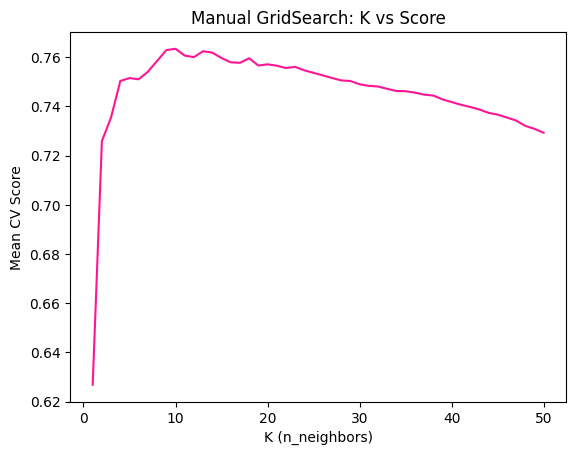

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


K_range = range(1,51)
mean_scores = []



for k in K_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=5)
    mean_scores.append(scores.mean())

best_k_manual = K_range[mean_scores.index(max(mean_scores))]
best_score_manual = max(mean_scores)

best_k_manual, best_score_manual

plt.figure()
plt.plot(K_range, mean_scores, color = "deeppink")
plt.xlabel("K (n_neighbors)")
plt.ylabel("Mean CV Score")
plt.title("Manual GridSearch: K vs Score")
plt.show()
    

❓GridSearchCV'yi böyle bir manuel döngüden daha iyi bir seçenek yapan şeyi tahmin edebilir misiniz?

<details>
    <summary>Cevap</summary>

- Sklearn'ın `n_jobs=-1` seçeneği aramayı paralelleştirmenize izin verir, tüm CPU çekirdeklerinizi kullanır
- Birlikte optimize edilecek birden fazla hiperparametreniz olsaydı ne olurdu?
</details>

## 5. Birden çok parametre ile GridSearch

👩🏻‍🏫 KNNRegressor, `p` hiperparametresi aracılığıyla çeşitli _mesafe metrikleri_ destekler

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Soru (birden çok parametreyi ayarlama)** ❓

* En iyi $K$ ve $p$'yi aynı anda aramak için GridSearchCV kullanın.
    * $K = [1, 5, 10, 20, 50]$ ve $p = [1, 2, 3]$ için tüm kombinasyonları deneyin.

In [81]:
knn = KNeighborsRegressor()
param_grid = {
    "n_neighbors": [1, 5, 10, 20, 50],
    "p": [1, 2, 3]
}

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
grid.fit(X_scaled, y)

grid.best_params_,grid.best_score_



({'n_neighbors': 5, 'p': 1}, 0.8041093755011985)

❓ **Soru (alt model sayısı)**❓

Toplamda kaç alt model eğittiniz?

<details>
    <summary>İpucu</summary>

15'ten çok daha fazla. İki kez düşün :)
    <details>
    <summary>Cevap</summary>

CV=5 nedeniyle 75 model
</details>

In [82]:
sub_models = 75
sub_models

75

❓ **Soru (modeli birden çok parametre ile ayarladıktan sonra en iyi parametreler ve en iyi skor)**❓

*En iyi parametreler* ve *en iyi skor* nedir?

In [83]:
grid.best_params_,grid.best_score_

({'n_neighbors': 5, 'p': 1}, 0.8041093755011985)

## 6. Rastgele Arama

Şimdi bir RandomizedSearch'ün aynı sayıda model yerleştirilerek daha iyi bir kombinasyon bulup bulamayacağını görelim.

❓ **Soru (RandomizedSearchCV)** ❓

`RandomizedSearchCV` kullanarak
- $K$'yı uniform `scipy.stats.randint(1,50)` ([döküman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)) dağılımından rastgele örnekle
- $p$'yi $[1,2,3]$ listesinden örnekle
- Önceki GridSearchCV'nizdeki ile tam olarak aynı sayıda model yerleştirmek için doğru `n_iter` ve `cv` sayılarını kullanın.

In [89]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint

knn = KNeighborsRegressor()
param_dist = {
    "n_neighbors":randint(1,50),
    "p": [1, 2, 3]
}

rand = RandomizedSearchCV(
    estimator=knn,
    param_distributions = param_dist,
    n_iter=15,
    cv=5,
    n_jobs=-1,
    random_state=42

)
rand.fit(X_scaled, y)

rand.best_params_ ,rand.best_score_

({'n_neighbors': 8, 'p': 1}, 0.8068073300064128)

## 7. Genelleme

❓ **Soru (modelinizi bir kez daha ince ayarlama)**❓

- İsterseniz RandomsearchCV'nizi rafine edin
- En iyi modelinizi seçin

In [92]:
best_search = rand

Şimdi `cv_results`'ınızı bir `DataFrame` olarak görüntülemeye çalışın, bu CV'nin içinde neler olup bittiğini görselleştirmenize yardımcı olacak! 😉

In [93]:
cv_results = pd.DataFrame(best_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003538,0.001392,0.023151,0.004419,39,1,"{'n_neighbors': 39, 'p': 1}",0.801098,0.780990,0.733003,0.787208,0.708278,0.762115,0.035360,6
1,0.003663,0.000613,0.244441,0.023307,15,3,"{'n_neighbors': 15, 'p': 3}",0.745631,0.752372,0.736175,0.766350,0.616500,0.723406,0.054349,14
2,0.003209,0.000677,0.016623,0.004096,8,1,"{'n_neighbors': 8, 'p': 1}",0.849931,0.774216,0.809730,0.840504,0.759655,0.806807,0.035466,1
3,0.002156,0.000495,0.213143,0.028858,21,3,"{'n_neighbors': 21, 'p': 3}",0.753457,0.753320,0.731799,0.766415,0.637897,0.728578,0.046682,10
4,0.001759,0.000661,0.209497,0.034329,19,3,"{'n_neighbors': 19, 'p': 3}",0.750361,0.755437,0.730801,0.766056,0.625538,0.725638,0.051341,13


❓ **Soru ("En iyi" modelin değerlendirmesi)** ❓

* "En iyi parametrelerle" modelimizin **görülmemiş** test seti `X_test` üzerindeki performansını keşfetme zamanı geldi.
    * Test seti için r2 skorunu hesaplayın ve `r2_test` olarak kaydedin.

In [94]:
best_model = best_search.best_estimator_
r2_test = best_model.score(X_test_scaled, y_test)
r2_test


0.8463369306673529

❓ **Soru (Bir adım geri çekilme)** ❓

Optimize edilmiş modelin iyi genelleme yaptığını düşünür müsünüz?

<details><summary>Cevap</summary>

Test skoru eğitim seti ile biraz azalabilir. Muhtemelen %5'ten fazla değil. Bunun nedeni şunlar olabilir:
- Temsili olmayan bir eğitim/test bölünmesi
- Model ayarlama aşamasında aşırı öğrenmeye yol açan çok küçük bir çapraz doğrulama sayısı. Ne kadar çok çapraz doğrulama yaparsanız, bulgularınız o kadar güçlü genelleşir - ancak veri setiniz çok küçükse cv'yi çok fazla artıramazsınız çünkü her katmanda temsili olmak için yeterli gözlemi tutamazsınız.
- Veri setimiz çok küçük ve hiperparametre optimizasyonumuz bu nedenle eğitim/test bölünmemize son derece bağımlı (ve aşırı uyum gösteriyor). Veri setinizin denediğiniz toplam hiperparametre kombinasyonu sayısından çok daha büyük olduğundan her zaman emin olun!
    
</details>

***🧪 Kodunuzu test edin***

In [95]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test=r2_test)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/D16D5-S-data-workflow/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 1 item

test_r2.py::TestR2::test_r2 PASSED                                       [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/r2.pickle

git commit -m 'Completed r2 step'

git push origin master



🏁 Tebrikler! Artık GridSearchCV veya RandomizedSearchCV kullanarak bir modeli nasıl ince ayarlayacağınızı biliyorsunuz

💾 Notebook'unuzu `git add/commit/push` yapmayı unutmayın...

🚀 ... ve bir sonraki meydan okumaya geçin!